# Face Recognition Using Sianese Network

In [1]:
# dependencies
# !pip install opencv-python matplotlib scikit-learn pandas tensorflow gradio

In [2]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

## Splitting test and train

In [3]:
image_df = pd.read_csv('../data/dataset_image_euclidian.csv')
train_df, test_df = train_test_split(image_df, test_size=0.5, random_state=42, stratify=image_df['similarity'])

In [4]:
train_df.head()

,input1_name,input1_path,input2_name,input2_path,similarity
194,Irene_Kahn,../raw_source/Irene_Kahn/Irene_Kahn_0001.jpg,Steve_Lenard,../raw_source/Steve_Lenard/Steve_Lenard_0001.jpg,0
14,nasandratra_harivonjy,../raw_source/nasandratra_harivonjy/nasandratr...,nasandratra_harivonjy,../raw_source/nasandratra_harivonjy/nasandratr...,1
108,Anna_Jones,../raw_source/Anna_Jones/Anna_Jones_0001.jpg,Jade_Jagger,../raw_source/Jade_Jagger/Jade_Jagger_0001.jpg,0
131,Avril_Lavigne,../raw_source/Avril_Lavigne/Avril_Lavigne_0001...,Zavad_Zarif,../raw_source/Zavad_Zarif/Zavad_Zarif_0001.jpg,0
216,Jacques_Villeneuve,../raw_source/Jacques_Villeneuve/Jacques_Ville...,Zhang_Yimou,../raw_source/Zhang_Yimou/Zhang_Yimou_0001.jpg,0


### Read image

In [5]:
def preprocess_image(img, target_size):
    img = cv2.resize(img, target_size)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255.0
    return img

In [6]:
def batch_process_images_generator(df, batch_size=128, target_size=(105, 105)):
    num_rows = len(df)
    while True:
        df = df.sample(frac=1).reset_index(drop=True)
        for start in range(0, num_rows, batch_size):
            end = min(start + batch_size, num_rows)
            batch_df = df.iloc[start:end]
            
            batch_images1 = []
            batch_images2 = []
            batch_similarity = []

            for index, row in batch_df.iterrows():
                
                img1 = cv2.imread(row['input1_path'])
                img2 = cv2.imread(row['input2_path'])

                if img1 is None or img2 is None:
                    continue

                img1 = preprocess_image(img1, target_size)
                img2 = preprocess_image(img2, target_size)
                    
                batch_images1.append(img1)
                batch_images2.append(img2)
                batch_similarity.append(row['similarity'])

            batch_images1 = np.array(batch_images1, dtype=np.float32)
            batch_images2 = np.array(batch_images2, dtype=np.float32)
            batch_similarity = np.array(batch_similarity)
            
            yield (batch_images1, batch_images2), batch_similarity

In [7]:
(input1, input2), similarity = next(batch_process_images_generator(train_df, batch_size=32))

1


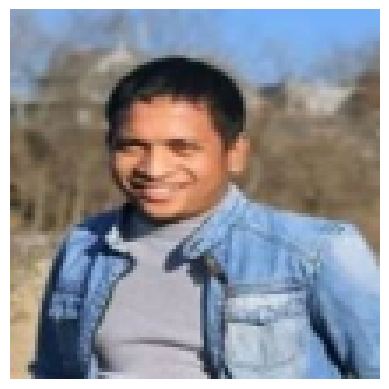

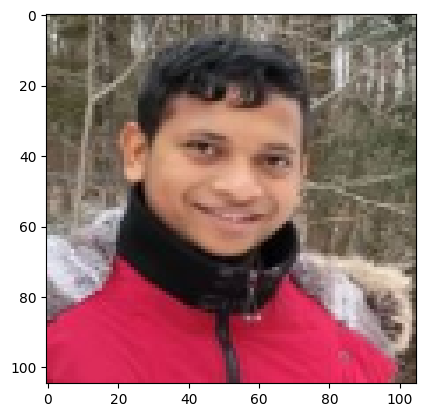

In [8]:
print(similarity[0])
plt.imshow(input1[0])
plt.axis("off")
plt.show()
plt.imshow(input2[0])
plt.show()

### Build the Model

In [9]:

def build_siamese_model(input_shape):
    input = Input(input_shape)
    x = Conv2D(64, (10, 10), activation='relu')(input)
    x = MaxPooling2D()(x)
    x = Conv2D(32, (7, 7), activation='relu')(x)
    x = Flatten()(x)
    x = Dense(4096, activation='sigmoid')(x)
    return Model(input, x)
    
def build_siamese_network(input_shape):
    base_model = build_siamese_model(input_shape)

    input1 = Input(shape=input_shape)
    input2 = Input(shape=input_shape)
    
    processed_1 = base_model(input1)
    processed_2 = base_model(input2)
    
    distance = Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]))([processed_1, processed_2])
    output = Dense(1, activation="sigmoid")(distance)
    model = Model([input1, input2], output)

    return model

In [ ]:
input_shape = (105, 105, 3)
model = build_siamese_network(input_shape)
model.compile(loss="binary_crossentropy", optimizer=Adam(), metrics=["accuracy"])

# Train the Model

In [ ]:
test_df.head()

In [ ]:
batch_size = 8
epochs = 2

train_dataset = batch_process_images_generator(train_df, batch_size=batch_size)
test_dataset = batch_process_images_generator(test_df, batch_size=batch_size)

steps_per_epoch = len(train_df) // batch_size
validation_steps = len(test_df) // batch_size

model.fit(train_dataset, 
          steps_per_epoch=steps_per_epoch, 
          epochs=epochs, 
          validation_data=test_dataset, 
          validation_split=0.2,
          validation_steps=validation_steps)


In [ ]:
# Gradio

In [ ]:
import gradio as gr

def predict(image1, image2):
    image1 = preprocess_image(image1, target_size=(180, 180))
    image2 = preprocess_image(image2, target_size=(180, 180))

    image1 = np.expand_dims(image1, axis=0)
    image2 = np.expand_dims(image2, axis=0)

    similarity = model.predict([image1, image2])
    return similarity[0][0]

interface = gr.Interface(fn=predict, 
                         inputs=[gr.inputs.Image(type="numpy"), gr.inputs.Image(type="numpy")], 
                         outputs="text")

interface.launch()
